In [1]:
# Data processing
import pandas as pd
import numpy as np

# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
import matplotlib
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim
import gensim.downloader as api

# Various
from datetime import datetime

# Showing the versions used
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('PyPlot version: {}'.format(matplotlib.__version__))
print('Scikit Learn version: {}'.format(sklearn.__version__))
print('Tensorflow version: {}'.format(tf.__version__))
print('Transformers version: {}'.format(transformers.__version__))
print('Regex version: {}'.format(re.__version__))
print('NLTK version: {}'.format(nltk.__version__))
print('Gensim version: {}'.format(gensim.__version__))

Pandas version: 1.3.4
Numpy version: 1.22.4
PyPlot version: 3.5.0
Scikit Learn version: 1.1.1
Tensorflow version: 2.9.1
Transformers version: 4.20.0
Regex version: 2.2.1
NLTK version: 3.7
Gensim version: 3.8.3


In [2]:
# Select the dataset for the analysis
dataset = 'bbc-text' # select 'bbc-text' or 'corona'

In [3]:
if dataset=='bbc-text':
    datapath = "datasets/bbc-text.csv"
if dataset=='corona':
    datapath="datasets/Corona_NLP_train.csv"

df = pd.read_csv(datapath)

if dataset=='corona':
    df.rename(columns={"Sentiment": "category", "OriginalTweet": "text"}, inplace=True)

df = df[["category", "text"]]

# Show the data
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["category"].value_counts())
print(40*'-')
nr_categories = len(df["category"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 2225
----------------------------------------
Split by category:
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
----------------------------------------
Number of categories: 5


In [5]:
# You can adjust n:
n=100
print('Category: ',df['category'][n])
print(100*'-')
print('Text:')
print(df['text'][n])

Category:  entertainment
----------------------------------------------------------------------------------------------------
Text:
housewives lift channel 4 ratings the debut of us television hit desperate housewives has helped lift channel 4 s january audience share by 12% compared to last year.  other successes such as celebrity big brother and the simpsons have enabled the broadcaster to surpass bbc two for the first month since last july. bbc two s share of the audience fell from 11.2% to 9.6% last month in comparison with january 2004. celebrity big brother attracted fewer viewers than its 2002 series.  comedy drama desperate housewives managed to pull in five million viewers at one point during its run to date  attracting a quarter of the television audience. the two main television channels  bbc1 and itv1  have both seen their monthly audience share decline in a year on year comparison for january  while five s proportion remained the same at a slender 6.3%. digital multi-chann

In [6]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# Use stopwords list from nltk (that is used in the function below)
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
# Let's apply this function to the whole corpus
df["text_clean"] = df["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
df.head()

,category,text,text_clean
0,tech,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


In [8]:
# Renaming, Input -> X, Output -> y
X = df['text_clean']
y = df['category']

In [9]:
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['category'])

In [10]:
y_train.value_counts()/y.value_counts()

sport            0.698630
business         0.700000
politics         0.700240
tech             0.700748
entertainment    0.699482
Name: category, dtype: float64

In [11]:
corpus = X_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

In [12]:
classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

print(training_time_tfidf)

1.459651


In [13]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 99.7%
Accuracy Test data: 97.9%
Training time: 1.5s


In [14]:
print('Classes of the model: ',classifier_tfidf.classes_)
print(80*'-')
print('Shape of the coefficients of the model (categories x vocabulary size): ',classifier_tfidf.coef_.shape)
print(80*'-')
NN = 10
# Get the 10 (here: NN, which you can adjust yourself) ids of the words with highest weights per category
top_words = np.argsort(classifier_tfidf.coef_,axis=1)[:,-NN:]

# Get the vocabulary of the model (mapping of words to ids):
voc = vectorizer_tfidf.vocabulary_
# Get the inverse vocabulary to map the ids of the words to the words:
inv_voc = {v: k for k, v in voc.items()}

# Get for each category (=class) the top ten words
for n, w in enumerate(classifier_tfidf.classes_):
    t = w + ': '
    for i in range(NN):
        t += inv_voc[top_words[n,i]]
        if i!=NN:
            t+=', '
    print(t)
    print(80*'-')

Classes of the model:  ['business' 'entertainment' 'politics' 'sport' 'tech']
--------------------------------------------------------------------------------
Shape of the coefficients of the model (categories x vocabulary size):  (5, 15000)
--------------------------------------------------------------------------------
business: economy, economic, price, growth, profit, market, bank, firm, share, company, 
--------------------------------------------------------------------------------
entertainment: chart, tv, singer, album, band, star, award, music, show, film, 
--------------------------------------------------------------------------------
politics: mp, blair, tory, lord, minister, election, government, labour, mr, party, 
--------------------------------------------------------------------------------
sport: team, season, england, coach, win, champion, cup, player, club, match, 
--------------------------------------------------------------------------------
tech: online, site, 

In [15]:
#Deep Learning - RNN

In [16]:
# Renaming, Input -> X, Output -> y
X_tf = df['text']
y_tf_class = df['category']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_tf_class)
y_tf = lab.transform(y_tf_class)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + y_tf_class[n] + ' is ', y_tf[n])

# Split into training and test data
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.3, random_state=42, stratify=df['category'])

Coding of labels into a one-hot vector: entertainment is  [0 1 0 0 0]


In [17]:
corpus = X_tf_train
max_words = 15000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [18]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=10 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (1557, 200)
----------------------------------------------------------------------------------------------------
Example:  [    4   317  1408  1309   651     3  4599   148    62   229    28  3974
   472     7   540     6  2012  1398   471 10401     6   574     4   198
     2   530     8   320    15  2160   265    56   409  1624     5     2
  4600  4601  2717     2  4881    14     2   198    15  1556    24     6
  1093   302     7     2    49  1575    34  8961     6   381    41     8
  1408   218    13     2  4881   304    14   477     4     2  4881     9
   860   581   112    52    10  1324  5208   823    13   416     2   457
     4   446    10  3619     5  2248     1     7     2   242  2161     2
  4881     9  1656     4   317  1408  1309    10  3793    28  1736  5598
     4  7138  1459    22    40    56  2362  1971   230  3487    28  6032
     3  6033     3  1625     5    20    73    39  1398   471   163   890
   238   409   180   320     9  1092     3   193     7    22  4599

In [19]:
# This may take several minutes
w2v = api.load("word2vec-google-news-300")
# Example of a word representation:
print(w2v['hello'].shape)

(300,)


In [20]:
# Build weights of the embbeddings matrix using w2v
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reverse_voc[i+1]
    if w in w2v:
        emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

In [26]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          4500300   
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               37920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 5)                 325       
                                                             

In [27]:
start_time = datetime.now()
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/10
25/25 [==============================] - 3s 56ms/step - loss: 1.3494 - accuracy: 0.4811 - val_loss: 0.9491 - val_accuracy: 0.6407
Epoch 2/10
25/25 [==============================] - 1s 38ms/step - loss: 1.0046 - accuracy: 0.6281 - val_loss: 0.7781 - val_accuracy: 0.7216
Epoch 3/10
25/25 [==============================] - 1s 38ms/step - loss: 0.7248 - accuracy: 0.7405 - val_loss: 0.4853 - val_accuracy: 0.8293
Epoch 4/10
25/25 [==============================] - 1s 38ms/step - loss: 0.5123 - accuracy: 0.8227 - val_loss: 0.4887 - val_accuracy: 0.8308
Epoch 5/10
25/25 [==============================] - 1s 37ms/step - loss: 0.3809 - accuracy: 0.8754 - val_loss: 0.3774 - val_accuracy: 0.8458
Epoch 6/10
25/25 [==============================] - 1s 37ms/step - loss: 0.3680 - accuracy: 0.8818 - val_loss: 0.2855 - val_accuracy: 0.9132
Epoch 7/10
25/25 [==============================] - 1s 38ms/step - loss: 0.2620 - accuracy: 0.9229 - val_loss: 0.2810 - val_accuracy: 0.9266
Epoch 8/10
25

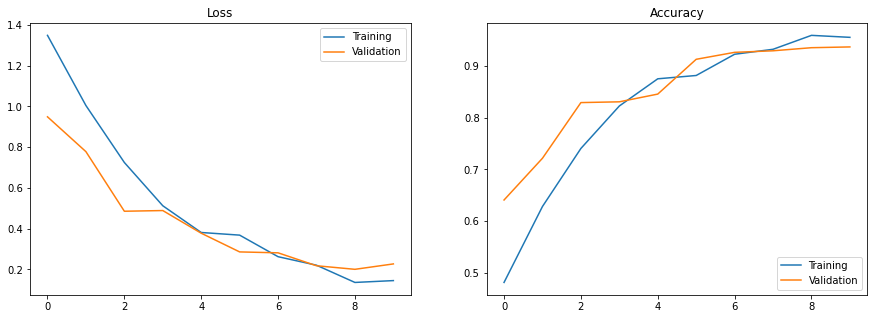

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [29]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 95.6%
Accuracy Test data: 93.7%
Training time: 11.8s
